# Drizzling WFPC2 Images to use a Single Zeropoint

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

Extra care must be taken when using `AstroDrizzle` to combine observations from detectors comprised of multiple chips of varying sensitivity. `AstroDrizzle` works with calibrated images in units of counts (electrons or Data Numbers) or count rates and not in units of flux. It assumes that all input frames can be converted to physical flux units using a single inverse-sensitivity factor, recorded in the FITS image headers as `PHOTFLAM`, and the output drizzled product simply copies the `PHOTFLAM` keyword value from the first input image. When this occurs, the inverse-sensitivity will vary across the final drizzled product, and users will need to keep track of which sources fell on which chip when doing photometry. Moreover, varying detector sensitivities will affect the cosmic-ray rejection algorithm used by `AstroDrizzle`, and this may result in the misidentification of some good pixels as cosmic rays.

This is a typical situation when drizzle-combining images from HST instruments with different chip sensitivities, e.g. Wide Field and Planetary Camera 2 (WFPC2). For more detail, see the section on [Gain Variation](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch53.html) under 'Position-Dependent Photometric Corrections' in the WFPC2 Data Handbook. As a result, each of the four chips requires a [unique PHOTFLAM](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch52.html#1933986) header keyword value. A similar situation may occur when drizzle-combining observations taken over a span of several years as detector's sensitivity declines over time, see e.g. [ACS ISR 2016-03](https://doi.org/10.3847/0004-6256/152/3/60).

One approach is to rescale the input data so that `AstroDrizzle` can properly assume the images/chips have the same sensitivity; that is, a single `PHOTFLAM` value can be used to convert re-scaled image counts (or count-rates) to physical _integrated_ flux units. The `photeq` task in `Drizzlepac` automates this image intensity rescaling to a single inverse-sensitivity factor `PHOTFLAM`.

In this example notebook, archival WFPC2 images are used to demonstrate advanced reprocessing using `TweakReg` and `AstroDrizzle` for alignment and image combination. The notebook is based on a prior WFPC2 [example](http://www.stsci.edu/hst/HST_overview/drizzlepac/examples/example7) but includes additional information about equalizing the chip sensitivities prior to combining. 

**NOTE:** It is important to note that `photeq` only adjusts image counts so that _integrated_ physical fluxes can be obtained using a single `PHOTFLAM`. It does nothing to account for different throughtputs at different wavelengths.

In [1]:
import shutil
import glob
import os
import subprocess

import matplotlib.pyplot as plt
from astropy.io import fits

from astroquery.mast import Observations
from stwcs.updatewcs import updatewcs
from drizzlepac import tweakreg, astrodrizzle, photeq
from stsci.skypac import skymatch

# ONLY needed for the simulation section:
import numpy as np
from stwcs.wcsutil import HSTWCS
from drizzlepac.wfpc2Data import WFPC2_GAINS

%matplotlib inline

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


## 1. Download the Data

This example uses WFPC2 observations of Messier 2 in the F814W filter. The data come from GO proposal [11100](http://www.stsci.edu/cgi-bin/get-proposal-info?id=11100&observatory=HST) _"Two new 'bullets' for MOND: revealing the properties of dark matter in massive merging clusters"_. Four images were acquired using a 4-pt dither box pattern, followed by two images offset with a dither-line pattern. 

The data are downloaded using the `astroquery` API to access the [MAST](http://archive.stsci.edu) archive. The `astroquery.mast` [documentation](http://astroquery.readthedocs.io/en/latest/mast/mast.html) has more examples for how to find and download data from MAST.

In [2]:
# Retrieve the observation information.
if os.path.isdir('mastDownload'):
    shutil.rmtree('mastDownload')
obs_table = Observations.query_criteria(obs_id='ua0605*', filters='F814W', obstype='ALL')
products = Observations.get_product_list(obs_table)

# Download only the ua0605*_c0m.fits and ua0605*_c1m.fits (DQ) images:
Observations.download_products(products, mrp_only=False, productSubGroupDescription=['C0M', 'C1M'], extension='fits')

# Move the files from the mastDownload directory to the current working
# directory and make a backup of the files.
fits_files = glob.glob('mastDownload/HST/ua*/ua*c?m.fits')
for fil in fits_files:
    base_name = os.path.basename(fil)
    if os.path.isfile(base_name):
        os.remove(base_name)
    shutil.move(fil, '.')
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


## 2. Update the WCS

WFPC2 images downloaded from the archive contain World Coordinate System (WCS) information based on an older-style description of image distortions. Before these images can be processed with `drizzlepac`, their WCS must be converted to a new format. This can be achieved using `updatewcs()` function from the `stwcs` package. More details may be found here: ['Making WFPC2 Images Compatible with AstroDrizzle'](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/ch45.html#601857). Note that `updatewcs` is no longer a parameter in AstroDrizzle or TweakReg and must be run separately before processing the data. 

First we download the reference files from the CRDS website. See the initialization notebook in this repository for more information.  

In [3]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = os.path.abspath(os.path.join('.', 'reference_files'))

subprocess.check_output('crds bestrefs --files ua0605*_c0m.fits --sync-references=1 --update-bestrefs', shell=True)

os.environ['uref'] = os.path.abspath(os.path.join('.', 'reference_files', 'references', 'hst', 'wfpc2')) + os.path.sep

**NOTE:** This next step may raise warnings because the Astrometry database is in progress and currently does not cover the entire sky. Please ignore these warnings. The WCS will still be updated.  

In [4]:
updatewcs('ua*c0m.fits', use_db=True)

    AstrometryDB called: https://mastdev.stsci.edu/portal/astrometryDB/


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


AstrometryDB not available.


NO Updates performed for ua060506m


Problems getting solutions from database


 NO Updates performed for ua060506m


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


AstrometryDB not available.


NO Updates performed for ua06050cm


Problems getting solutions from database


 NO Updates performed for ua06050cm


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


AstrometryDB not available.


NO Updates performed for ua06050am


Problems getting solutions from database


 NO Updates performed for ua06050am


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


AstrometryDB not available.


NO Updates performed for ua060504m


Problems getting solutions from database


 NO Updates performed for ua060504m


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


AstrometryDB not available.


NO Updates performed for ua060508m


Problems getting solutions from database


 NO Updates performed for ua060508m


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


AstrometryDB not available.


NO Updates performed for ua060502m


Problems getting solutions from database


 NO Updates performed for ua060502m


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


['ua060506m_c0m.fits',
 'ua06050cm_c0m.fits',
 'ua06050am_c0m.fits',
 'ua060504m_c0m.fits',
 'ua060508m_c0m.fits',
 'ua060502m_c0m.fits']

### Backup an Image

In a later section we will generate simulated data to illustrate the effects of drizzling WFPC2 images without sensitivity equalization. For that purpose we will need a copy of an original image that has the original inverse-sensitivity values (`PHOTFLAM`) in their headers. Here we create a backup copy of the first image.

**NOTE:** This step is needed for illustration purpose in this notebook only. It is not needed when processing data.

In [5]:
orig_image = glob.glob('ua*c0m.fits')[0]
backup_image = 'simulation.fits'
if os.path.isfile(backup_image):
    os.remove(backup_image)
shutil.copy2(orig_image, backup_image)

'simulation.fits'

## 3. Align the Images

Due to small pointing errors, the image header WCS typically needs to be updated in order to achieve the best drizzle-combined products. The expected pointing accuracy for various observing scenerios is summarized in the DrizzlePac Handbook [Appendix B](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/AppendixB2.html). Input images must first be aligned so that when the coordinates of a given object (in detector space) are converted to sky coordinates (using the WCS), that object's sky coordinates must be approximately equal in each frame. 

The `DrizzlePac` task `TweakReg` may be used to correct for any errors in the image header WCS. First, `TweakReg` finds sources in each image, matches sources in common across images, and finds a separate linear transformation to align each image. `TweakReg` then computes a new WCS for each image based on this linear transformation.

Here we show a basic image alignment procedure. For a more detailed illustration of image alignment, please refer to other example notebooks such as the mosaic example in this repository.

Setting up logfile :  tweakreg.log


TweakReg Version 1.4.7(18-April-2018) started at: 14:54:36.628 (26/03/2019) 


Version Information


--------------------


Python Version [GCC 7.3.0]


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


numpy Version -> 1.15.4 


astropy Version -> 3.1.2 


stwcs Version -> 1.4.2 


Finding shifts for: 


    ua060506m_c0m.fits


    ua06050cm_c0m.fits


    ua06050am_c0m.fits


    ua060504m_c0m.fits


    ua060508m_c0m.fits


    ua060502m_c0m.fits


===  Source finding for image 'ua060506m_c0m.fits':


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 1) started at: 14:54:36.715 (26/03/2019)


     Found 19 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 2) started at: 14:54:36.94 (26/03/2019)


     Found 76 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 3) started at: 14:54:37.143 (26/03/2019)


     Found 241 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 4) started at: 14:54:37.422 (26/03/2019)


     Found 105 objects.


===  FINAL number of objects in image 'ua060506m_c0m.fits': 441


===  Source finding for image 'ua06050cm_c0m.fits':


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 1) started at: 14:54:37.958 (26/03/2019)


     Found 30 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 2) started at: 14:54:38.064 (26/03/2019)

     Found 67 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 3) started at: 14:54:38.308 (26/03/2019)


     Found 512 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 4) started at: 14:54:38.557 (26/03/2019)


     Found 282 objects.


===  FINAL number of objects in image 'ua06050cm_c0m.fits': 891


===  Source finding for image 'ua06050am_c0m.fits':


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 1) started at: 14:54:39.091 (26/03/2019)


     Found 26 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 2) started at: 14:54:39.240 (26/03/2019)


     Found 187 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 3) started at: 14:54:39.435 (26/03/2019)


     Found 301 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 4) started at: 14:54:39.654 (26/03/2019)


     Found 130 objects.


===  FINAL number of objects in image 'ua06050am_c0m.fits': 644


===  Source finding for image 'ua060504m_c0m.fits':


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 1) started at: 14:54:40.153 (26/03/2019)


     Found 13 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 2) started at: 14:54:40.322 (26/03/2019)


     Found 75 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 3) started at: 14:54:40.523 (26/03/2019)


     Found 407 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 4) started at: 14:54:40.803 (26/03/2019)


     Found 237 objects.


===  FINAL number of objects in image 'ua060504m_c0m.fits': 732


===  Source finding for image 'ua060508m_c0m.fits':


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 1) started at: 14:54:41.315 (26/03/2019)


     Found 15 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 2) started at: 14:54:41.448 (26/03/2019)


     Found 130 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 3) started at: 14:54:41.646 (26/03/2019)


     Found 280 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 4) started at: 14:54:41.913 (26/03/2019)


     Found 411 objects.


===  FINAL number of objects in image 'ua060508m_c0m.fits': 836


===  Source finding for image 'ua060502m_c0m.fits':


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 1) started at: 14:54:42.378 (26/03/2019)


     Found 14 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 2) started at: 14:54:42.542 (26/03/2019)


     Found 83 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 3) started at: 14:54:42.749 (26/03/2019)


     Found 304 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 4) started at: 14:54:43.034 (26/03/2019)


     Found 116 objects.


===  FINAL number of objects in image 'ua060502m_c0m.fits': 517


Performing alignment in the projection plane defined by the WCS


derived from 'ua060506m_c0m.fits'


Performing fit for: ua06050cm_c0m.fits


Matching sources from 'ua06050cm_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.545287147216925 -1.0225598744896551


    with significance of  414.9942168271746 and  22.0  matches


Found 37 matches for ua06050cm_c0m.fits...


Computed  rscale  fit for  ua06050cm_c0m.fits : 


XSH: -0.0867  YSH: -0.2208    ROT: 0.0009291644216    SCALE: 0.999892


XRMS: 0.17    YRMS: 0.15


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.5e-06 (deg)


Final solution based on  36  objects.


wrote XY data to:  ua06050cm_c0m_catalog_fit.match


Total # points:  36


# of points after clipping:  36


Total # points:  36


# of points after clipping:  36


Initializing new WCSCORR table for  ua06050cm_c0m.fits


....Updating header for ua06050cm_c0m.fits...


Processing ua06050cm_c0m.fits['SCI',1]


Updating header for ua06050cm_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4618034882911754e-06 -1.241055041367333e-05


CD_21  CD_22: -1.2412146303222932e-05 -2.4762700964097313e-06


CRVAL    : 323.3149888244128 -0.8703848650823858


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04554921252570859


ORIENTAT : -101.2840056480147


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',2]


Updating header for ua06050cm_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7094851679946594e-05 -5.648978157652841e-06


CD_21  CD_22: -5.64665432592657e-06 2.709154120443237e-05


CRVAL    : 323.30625517805623 -0.856091940749758


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962639245346323


ORIENTAT : -11.77823482484176


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',3]


Updating header for ua06050cm_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.501442520918017e-06 2.711974555140299e-05


CD_21  CD_22: 2.7119043726208366e-05 5.497981234409792e-06


CRVAL    : 323.3266946842206 -0.8520979633894329


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960640775906755


ORIENTAT : 78.53975507148988


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',4]


Updating header for ua06050cm_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7185218202273922e-05 5.240584757971837e-06


CD_21  CD_22: 5.235488350297237e-06 -2.7189873675766312e-05


CRVAL    : 323.3309136964112 -0.8730097848219144


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965439873691254


ORIENTAT : 169.09057153340257


WCSNAME  :  TWEAK


Performing fit for: ua06050am_c0m.fits


Matching sources from 'ua06050am_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.43824902404977095 -0.954378056307835


    with significance of  336.6570027490888 and  15.0  matches


Found 29 matches for ua06050am_c0m.fits...


Computed  rscale  fit for  ua06050am_c0m.fits : 


XSH: -0.0116  YSH: -0.1765    ROT: 359.9996395    SCALE: 0.999926


XRMS: 0.17    YRMS: 0.15


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.5e-06 (deg)


Final solution based on  28  objects.


wrote XY data to:  ua06050am_c0m_catalog_fit.match


Total # points:  28


# of points after clipping:  28


Total # points:  28


# of points after clipping:  28


Initializing new WCSCORR table for  ua06050am_c0m.fits


....Updating header for ua06050am_c0m.fits...


Processing ua06050am_c0m.fits['SCI',1]


Updating header for ua06050am_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4620087340865274e-06 -1.2410121052060416e-05


CD_21  CD_22: -1.2411717122483129e-05 -2.476474862748193e-06


CRVAL    : 323.31476004105775 -0.870994711666098


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04554940414591529


ORIENTAT : -101.2852952070008


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',2]


Updating header for ua06050am_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7093908718402853e-05 -5.649417700916336e-06


CD_21  CD_22: -5.6470940931968676e-06 2.7090598316484278e-05


CRVAL    : 323.30602633456033 -0.8567024142480669


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962681151551943


ORIENTAT : -11.779524194534824


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',3]


Updating header for ua06050am_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.501887316177581e-06 2.711880515936066e-05


CD_21  CD_22: 2.711810332242059e-05 5.498426164069311e-06


CRVAL    : 323.32646513861334 -0.8527080971630889


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960682680751902


ORIENTAT : 78.53846526417668


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',4]


Updating header for ua06050am_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.718428178977977e-05 5.2410389062708275e-06


CD_21  CD_22: 5.235942663331838e-06 -2.7188936992037302e-05


CRVAL    : 323.3306844952106 -0.8736191939619983


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.0996548178526407


ORIENTAT : 169.08928196114087


WCSNAME  :  TWEAK


Performing fit for: ua060504m_c0m.fits


Matching sources from 'ua060504m_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.6287966609589972 -0.9776338702613252


    with significance of  494.5252268590552 and  26.0  matches


Found 39 matches for ua060504m_c0m.fits...


Computed  rscale  fit for  ua060504m_c0m.fits : 


XSH: -0.0123  YSH: -0.1363    ROT: 0.004152026222    SCALE: 1.000025


XRMS: 0.16    YRMS: 0.15


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.4e-06 (deg)


Final solution based on  36  objects.


wrote XY data to:  ua060504m_c0m_catalog_fit.match


Total # points:  36


# of points after clipping:  36


Total # points:  36


# of points after clipping:  36


Initializing new WCSCORR table for  ua060504m_c0m.fits


....Updating header for ua060504m_c0m.fits...


Processing ua060504m_c0m.fits['SCI',1]


Updating header for ua060504m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4608649817155327e-06 -1.2409477659325429e-05


CD_21  CD_22: -1.2411072504059743e-05 -2.475330242173957e-06


CRVAL    : 323.31494075742626 -0.8704567665962525


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555083662190098


ORIENTAT : -101.28078279103673


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',2]


Updating header for ua060504m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.709252305512509e-05 -5.646902658198409e-06


CD_21  CD_22: -5.644578953151266e-06 2.7089213064327985e-05


CRVAL    : 323.30620876783996 -0.856164747001681


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.0996299446720908


ORIENTAT : -11.775011839623488


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',3]


Updating header for ua060504m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.499379989534108e-06 2.7117406159828695e-05


CD_21  CD_22: 2.7116704635602087e-05 5.495919011330259e-06


CRVAL    : 323.32664650286523 -0.8521723091714779


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960995931780645


ORIENTAT : 78.54297782014547


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',4]


Updating header for ua060504m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7182857655783963e-05 5.238543624129633e-06


CD_21  CD_22: 5.233448028258839e-06 -2.718751296331227e-05


CRVAL    : 323.3308639267975 -0.8730823255521176


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965795192213613


ORIENTAT : 169.09379449691806


WCSNAME  :  TWEAK


Performing fit for: ua060508m_c0m.fits


Matching sources from 'ua060508m_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.37104472297450286 -0.954378056307835


    with significance of  360.21342879703184 and  17.0  matches


Found 35 matches for ua060508m_c0m.fits...


Computed  rscale  fit for  ua060508m_c0m.fits : 


XSH: 0.0631  YSH: -0.1795    ROT: 0.004255732166    SCALE: 0.999965


XRMS: 0.13    YRMS: 0.15


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 2e-06 (deg)


Final solution based on  34  objects.


wrote XY data to:  ua060508m_c0m_catalog_fit.match


Total # points:  34


# of points after clipping:  34


Total # points:  34


# of points after clipping:  34


Initializing new WCSCORR table for  ua060508m_c0m.fits


....Updating header for ua060508m_c0m.fits...


Processing ua060508m_c0m.fits['SCI',1]


Updating header for ua060508m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4609362023453072e-06 -1.2409954964884337e-05


CD_21  CD_22: -1.2411549797879451e-05 -2.4754020864208434e-06


CRVAL    : 323.3151845900449 -0.8706181617416513


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.045549817686568114


ORIENTAT : -101.28067904748686


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',2]


Updating header for ua060508m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7093565462080784e-05 -5.647068774240818e-06


CD_21  CD_22: -5.644744930899228e-06 2.7090255313342635e-05


CRVAL    : 323.306452293309 -0.8563255818542874


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962771605323506


ORIENTAT : -11.774908169236648


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',3]


Updating header for ua060508m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.499540415831139e-06 2.711844918760446e-05


CD_21  CD_22: 2.7117747618073577e-05 5.496079275898442e-06


CRVAL    : 323.326890815034 -0.8523330289212083


CRPIX    : 425.0 425.0


NAXIS    : 800 800

Plate Scale : 0.09960773111614668


ORIENTAT : 78.5430815795775


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',4]


Updating header for ua060508m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7183902756065957e-05 5.238694030008452e-06


CD_21  CD_22: 5.2335982180745815e-06 -2.7188558223053365e-05


CRVAL    : 323.3311083619725 -0.8732438495412219


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965572280724205


ORIENTAT : 169.09389811799934


WCSNAME  :  TWEAK


Performing fit for: ua060502m_c0m.fits


Matching sources from 'ua060502m_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of  -0.8988225007522779 -0.8988225007522779


    with significance of  552.8960119226762 and  28.0  matches


Found 35 matches for ua060502m_c0m.fits...


Computed  rscale  fit for  ua060502m_c0m.fits : 


XSH: -0.0966  YSH: -0.1780    ROT: 0.002473501445    SCALE: 1.000023


XRMS: 0.16    YRMS: 0.15


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.3e-06 (deg)


Final solution based on  35  objects.


wrote XY data to:  ua060502m_c0m_catalog_fit.match


Total # points:  35


# of points after clipping:  35


Total # points:  35


# of points after clipping:  35


Initializing new WCSCORR table for  ua060502m_c0m.fits


....Updating header for ua060502m_c0m.fits...


Processing ua060502m_c0m.fits['SCI',1]


Updating header for ua060502m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4612517738326104e-06 -1.2409522036996026e-05


CD_21  CD_22: -1.2411117377177763e-05 -2.4757171015594216e-06


CRVAL    : 323.3147111644507 -0.8710690248145815


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555116863410184


ORIENTAT : -101.28246128655054


WCSNAME  :  TWEAK


Processing ua060502m_c0m.fits['SCI',2]


Updating header for ua060502m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7092613002679305e-05 -5.647749461360079e-06


CD_21  CD_22: -5.645425788038162e-06 2.7089302906533045e-05


CRVAL    : 323.30597867246 -0.8567771263270793


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.099630670803459


ORIENTAT : -11.776690329071132


WCSNAME  :  TWEAK


Processing ua060502m_c0m.fits['SCI',3]


Updating header for ua060502m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.500226244437722e-06 2.711750061664414e-05


CD_21  CD_22: 2.711679898740342e-05 5.496765251874163e-06


CRVAL    : 323.32641648633665 -0.8527840522140662


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09961068533848494


ORIENTAT : 78.5412992307214


WCSNAME  :  TWEAK


Processing ua060502m_c0m.fits['SCI',4]


Updating header for ua060502m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7182960487114978e-05 5.239389578977535e-06


CD_21  CD_22: 5.234293747609925e-06 -2.7187615636044817e-05


CRVAL    : 323.330634563371 -0.8736941420657863


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965867839434511


ORIENTAT : 169.0921157404893


WCSNAME  :  TWEAK


Initializing new WCSCORR table for  ua060506m_c0m.fits


Trailer file written to:  tweakreg.log


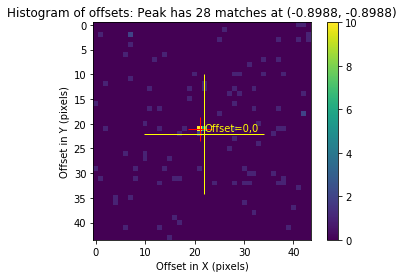

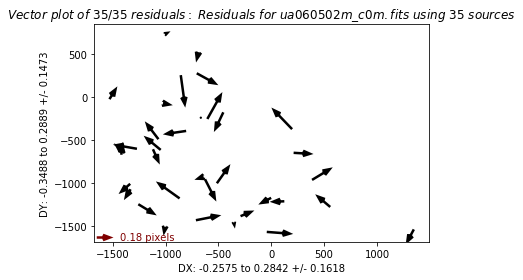

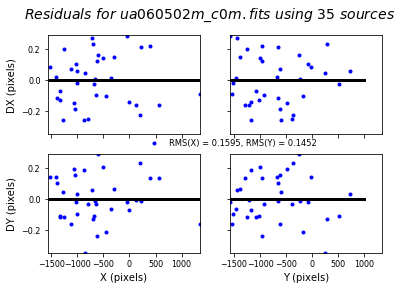

In [6]:
tweakreg.TweakReg('ua*c0m.fits', updatehdr=True, reusename=True, interactive=False,
                  conv_width=3.0, threshold=300.0, peakmin=100, peakmax=10000)

## 4. Equalize the chip sensitivities

This step adjusts image data values so that all images and chips appear (to `AstroDrizzle`) to have a single inverse sensitivity (`PHOTFLAM`). This can be achieved using the `photeq` task in `Drizzlepac`. This task adjusts image data so that when these data are multiplied by the same single `PHOTFLAM` value, the correct flux is obtained.

In [7]:
photeq.photeq(files='ua*_c0m.fits', ref_phot_ext=3, readonly=False)

***** drizzlepac.photeq started on 2019-03-26 14:54:50.874313


      Version 0.2 (06-Nov-2015)


PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM


SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU


REFERENCE VALUE FROM FILE: 'ua060506m_c0m.fits[3]'


REFERENCE 'PHOTFLAM' VALUE IS: 2.449067e-18


Processing file 'ua060506m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3) - This is the "reference" extension.


          Nothing to do. Skipping this extension...


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua06050cm_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua06050am_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060504m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060508m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060502m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Done.


In the above command, we instruct `photeq` to "equalize" all chips of all input images using the `PHOTFLAM` for the `WF3` chip (`ref_phot_ext=3`), using the first image as a reference. This reference `PHOTFLAM` value is reported in the log file:

```
REFERENCE VALUE FROM FILE: 'ua060502m_c0m.fits['SCI',1]'
REFERENCE 'PHOTFLAM' VALUE IS: 2.507987e-18
```

Upon the completion, `photeq` will not only adjust image data but also update `PHOTFLAM` values for all chips to this specific reference value.

## 5. Drizzle-combine the images

All four chips are now drizzled together with an output pixel scale set to that of the WF chips:

In [8]:
astrodrizzle.AstroDrizzle('ua*c0m.fits',
                          preserve=False,
                          driz_sep_bits='8,1024',
                          driz_sep_wcs=True,
                          driz_sep_scale=0.0996,
                          combine_type='median',
                          driz_cr_snr='5.5 3.5',
                          driz_cr_scale='2.0 1.5',
                          final_fillval=None,
                          final_bits='8,1024',
                          final_wcs=True,
                          final_scale=0.0996)

Setting up logfile :  astrodrizzle.log


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:54:51.436 (26/03/2019)


==== Processing Step  Initialization  started at  14:54:51.438 (26/03/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.31866141760236  -0.8646750559137655  


CRPIX : 777.9854781573196  767.6957940734234  


CD1_1 CD1_2  : 5.413908726936502e-06  -2.7131790149948548e-05  


CD2_1 CD2_2  : -2.7131790149948548e-05  -5.413908726936502e-06  


NAXIS : 1555  1534


********************************************************************************


*


*  Estimated memory usage:  up to 772 Mb.


*  Output image size:       1555 X 1534 pixels. 


*  Output image file:       ~ 27 Mb. 


*  Cores available:         24


*


********************************************************************************


==== Processing Step  Initialization  finished at  14:54:54.43 (26/03/2019)


==== Processing Step  Static Mask  started at  14:54:54.437 (26/03/2019)


==== Processing Step  Static Mask  finished at  14:54:55.730 (26/03/2019)


==== Processing Step  Subtract Sky  started at  14:54:55.732 (26/03/2019)


***** skymatch started on 2019-03-26 14:54:56.676199


      Version 1.0.2 (2019-03-07 00:54:44 -0500)


'skymatch' task will apply computed sky differences to input image file(s).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


'MDRIZSKY' header keyword will represent sky value *computed* from data.


-----  User specified keywords:  -----


       Sky Value Keyword:  'MDRIZSKY'


       Data Units Keyword: 'BUNIT'


-----  Input file list:  -----


   **  Input image: 'ua060502m_c0m.fits'


       EXT: 'SCI',1;	MASK: ua060502m_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua060502m_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua060502m_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua060502m_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua060504m_c0m.fits'


       EXT: 'SCI',1;	MASK: ua060504m_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua060504m_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua060504m_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua060504m_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua060506m_c0m.fits'


       EXT: 'SCI',1;	MASK: ua060506m_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua060506m_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua060506m_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua060506m_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua060508m_c0m.fits'


       EXT: 'SCI',1;	MASK: ua060508m_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua060508m_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua060508m_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua060508m_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua06050am_c0m.fits'


       EXT: 'SCI',1;	MASK: ua06050am_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua06050am_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua06050am_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua06050am_skymatch_mask_sci4.fits[0]


   **  Input image: 'ua06050cm_c0m.fits'


       EXT: 'SCI',1;	MASK: ua06050cm_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',2;	MASK: ua06050cm_skymatch_mask_sci2.fits[0]


       EXT: 'SCI',3;	MASK: ua06050cm_skymatch_mask_sci3.fits[0]


       EXT: 'SCI',4;	MASK: ua06050cm_skymatch_mask_sci4.fits[0]


-----  Sky statistics parameters:  -----


       statistics function: 'median'


       lower = None


       upper = None


       nclip = 5


       lsigma = 4.0


       usigma = 4.0


       binwidth = 0.1


-----  Data->Brightness conversion parameters for input files:  -----


   *   Image: ua060502m_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua060504m_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua060506m_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua060508m_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua06050am_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


   *   Image: ua06050cm_c0m.fits


       EXT = 'SCI',1


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  48.199471583929096


       EXT = 'SCI',2


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.075222287537429


       EXT = 'SCI',3


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.079268189497055


       EXT = 'SCI',4


             Data units type: COUNTS


             EXPTIME: 10.0 [s]


             Conversion factor (data->brightness):  10.069561513886038


-----  Computing sky values requested image extensions (detector chips):  -----


   *   Image:   'ua060502m_c0m.fits['SCI',1,2,3,4]'  --  SKY = -17.481034058661276 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.362681   NEW MDRIZSKY = -0.362681


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.73505   NEW MDRIZSKY = -1.73505


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.73436   NEW MDRIZSKY = -1.73436


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.73603   NEW MDRIZSKY = -1.73603


   *   Image:   'ua060504m_c0m.fits['SCI',1,2,3,4]'  --  SKY = -19.184347898616416 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.39802   NEW MDRIZSKY = -0.39802


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.90411   NEW MDRIZSKY = -1.90411


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.90335   NEW MDRIZSKY = -1.90335


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.90518   NEW MDRIZSKY = -1.90518


   *   Image:   'ua060506m_c0m.fits['SCI',1,2,3,4]'  --  SKY = -17.294534642007278 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.358812   NEW MDRIZSKY = -0.358812


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.71654   NEW MDRIZSKY = -1.71654


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.71585   NEW MDRIZSKY = -1.71585


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.71751   NEW MDRIZSKY = -1.71751


   *   Image:   'ua060508m_c0m.fits['SCI',1,2,3,4]'  --  SKY = -19.75838883105671 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.40993   NEW MDRIZSKY = -0.40993


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.96109   NEW MDRIZSKY = -1.96109


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.9603   NEW MDRIZSKY = -1.9603


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.96219   NEW MDRIZSKY = -1.96219


   *   Image:   'ua06050am_c0m.fits['SCI',1,2,3,4]'  --  SKY = -18.018405137456174 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.37383   NEW MDRIZSKY = -0.37383


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.78839   NEW MDRIZSKY = -1.78839


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.78767   NEW MDRIZSKY = -1.78767


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.78939   NEW MDRIZSKY = -1.78939


   *   Image:   'ua06050cm_c0m.fits['SCI',1,2,3,4]'  --  SKY = -10.481485413650148 (brightness units)


       Sky change (data units):


      - EXT = 'SCI',1   delta(MDRIZSKY) = -0.217461   NEW MDRIZSKY = -0.217461


      - EXT = 'SCI',2   delta(MDRIZSKY) = -1.04032   NEW MDRIZSKY = -1.04032


      - EXT = 'SCI',3   delta(MDRIZSKY) = -1.03991   NEW MDRIZSKY = -1.03991


      - EXT = 'SCI',4   delta(MDRIZSKY) = -1.04091   NEW MDRIZSKY = -1.04091


***** skymatch ended on 2019-03-26 14:54:59.149579


TOTAL RUN TIME: 0:00:02.473380


==== Processing Step  Subtract Sky  finished at  14:54:59.420 (26/03/2019)


==== Processing Step  Separate Drizzle  started at  14:54:59.421 (26/03/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.31866141760236  -0.8646750559137655  


CRPIX : 777.9854781573196  767.6957940734234  


CD1_1 CD1_2  : 5.413908726936502e-06  -2.7131790149948548e-05  


CD2_1 CD2_2  : -2.7131790149948548e-05  -5.413908726936502e-06  


NAXIS : 1555  1534


-Generating simple FITS output: ua060504m_c0m_single_sci.fits


-Generating simple FITS output: ua060506m_c0m_single_sci.fits


-Generating simple FITS output: ua06050cm_c0m_single_sci.fits


-Generating simple FITS output: ua060502m_c0m_single_sci.fits


-Generating simple FITS output: ua060508m_c0m_single_sci.fits


Writing out image to disk: ua060506m_c0m_single_sci.fits


Writing out image to disk: ua060502m_c0m_single_sci.fits


Writing out image to disk: ua06050cm_c0m_single_sci.fits


Writing out image to disk: ua060504m_c0m_single_sci.fits


Writing out image to disk: ua060508m_c0m_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Writing out image to disk: ua060506m_c0m_single_wht.fits


Deleted all instances of WCS with key B in extensions [0]


-Generating simple FITS output: ua06050am_c0m_single_sci.fits


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Writing out image to disk: ua060502m_c0m_single_wht.fits


Writing out image to disk: ua060508m_c0m_single_wht.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua06050cm_c0m_single_wht.fits


Writing out image to disk: ua060504m_c0m_single_wht.fits


Writing out image to disk: ua06050am_c0m_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua06050am_c0m_single_wht.fits


==== Processing Step  Separate Drizzle  finished at  14:55:04.403 (26/03/2019)


==== Processing Step  Create Median  started at  14:55:04.406 (26/03/2019)


reference sky value for image 'ua060502m_c0m.fits' is -2.582288942337036


reference sky value for image 'ua060504m_c0m.fits' is -2.8339015460014347


reference sky value for image 'ua060506m_c0m.fits' is -2.5547393488883974


reference sky value for image 'ua060508m_c0m.fits' is -2.9186985635757448


reference sky value for image 'ua06050am_c0m.fits' is -2.661669108867646


reference sky value for image 'ua06050cm_c0m.fits' is -1.5483193838596345


Saving output median image to: 'final_med.fits'


==== Processing Step  Create Median  finished at  14:55:05.737 (26/03/2019)


==== Processing Step  Blot  started at  14:55:05.738 (26/03/2019)


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci1_blt.fits


Writing out image to disk: ua060502m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci2_blt.fits


Writing out image to disk: ua060502m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci3_blt.fits


Writing out image to disk: ua060502m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci4_blt.fits


Writing out image to disk: ua060502m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci1_blt.fits


Writing out image to disk: ua060504m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci2_blt.fits


Writing out image to disk: ua060504m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci3_blt.fits


Writing out image to disk: ua060504m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci4_blt.fits


Writing out image to disk: ua060504m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci1_blt.fits


Writing out image to disk: ua060506m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci2_blt.fits


Writing out image to disk: ua060506m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci3_blt.fits


Writing out image to disk: ua060506m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci4_blt.fits


Writing out image to disk: ua060506m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci1_blt.fits


Writing out image to disk: ua060508m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci2_blt.fits


Writing out image to disk: ua060508m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci3_blt.fits


Writing out image to disk: ua060508m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci4_blt.fits


Writing out image to disk: ua060508m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci1_blt.fits


Writing out image to disk: ua06050am_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci2_blt.fits


Writing out image to disk: ua06050am_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci3_blt.fits


Writing out image to disk: ua06050am_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci4_blt.fits


Writing out image to disk: ua06050am_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci1_blt.fits


Writing out image to disk: ua06050cm_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci2_blt.fits


Writing out image to disk: ua06050cm_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci3_blt.fits


Writing out image to disk: ua06050cm_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci4_blt.fits


Writing out image to disk: ua06050cm_c0m_sci4_blt.fits


==== Processing Step  Blot  finished at  14:55:18.998 (26/03/2019)


==== Processing Step  Driz_CR  started at  14:55:19.00 (26/03/2019)


Creating output :  ua060508m_c0m_sci1_crmask.fits


Creating output :  ua060502m_c0m_sci1_crmask.fits


Creating output :  ua06050cm_c0m_sci1_crmask.fits


Creating output :  ua060504m_c0m_sci1_crmask.fits


Creating output :  ua06050am_c0m_sci1_crmask.fits


Creating output :  ua060506m_c0m_sci1_crmask.fits


Creating output :  ua060508m_c0m_sci2_crmask.fits


Creating output :  ua06050cm_c0m_sci2_crmask.fits


Creating output :  ua060502m_c0m_sci2_crmask.fits


Creating output :  ua060504m_c0m_sci2_crmask.fits


Creating output :  ua06050am_c0m_sci2_crmask.fits


Creating output :  ua060506m_c0m_sci2_crmask.fits


Creating output :  ua060502m_c0m_sci3_crmask.fits


Creating output :  ua060508m_c0m_sci3_crmask.fits


Creating output :  ua06050cm_c0m_sci3_crmask.fits


Creating output :  ua060504m_c0m_sci3_crmask.fits


Creating output :  ua06050am_c0m_sci3_crmask.fits


Creating output :  ua060506m_c0m_sci3_crmask.fits


Creating output :  ua060502m_c0m_sci4_crmask.fits


Creating output :  ua060508m_c0m_sci4_crmask.fits


Creating output :  ua06050cm_c0m_sci4_crmask.fits


Creating output :  ua060504m_c0m_sci4_crmask.fits


Creating output :  ua060506m_c0m_sci4_crmask.fits


Creating output :  ua06050am_c0m_sci4_crmask.fits


==== Processing Step  Driz_CR  finished at  14:55:41.21 (26/03/2019)


==== Processing Step  Final Drizzle  started at  14:55:41.234 (26/03/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.31866141760236  -0.8646750559137655  


CRPIX : 777.9854781573196  767.6957940734234  


CD1_1 CD1_2  : 5.413908726936502e-06  -2.7131790149948548e-05  


CD2_1 CD2_2  : -2.7131790149948548e-05  -5.413908726936502e-06  


NAXIS : 1555  1534


-Generating simple FITS output: final_drz_sci.fits


Writing out image to disk: final_drz_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: final_drz_wht.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: final_drz_ctx.fits


==== Processing Step  Final Drizzle  finished at  14:55:54.164 (26/03/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:55:54.166 (26/03/2019).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          2.9978 sec.


            Static Mask          1.2928 sec.


           Subtract Sky          3.6878 sec.


       Separate Drizzle          4.9821 sec.


          Create Median          1.3310 sec.


                   Blot          13.2601 sec.


                Driz_CR          22.2185 sec.


          Final Drizzle          12.9298 sec.


   ====================          ====================


                  Total          62.6998 sec.


Trailer file written to:  astrodrizzle.log


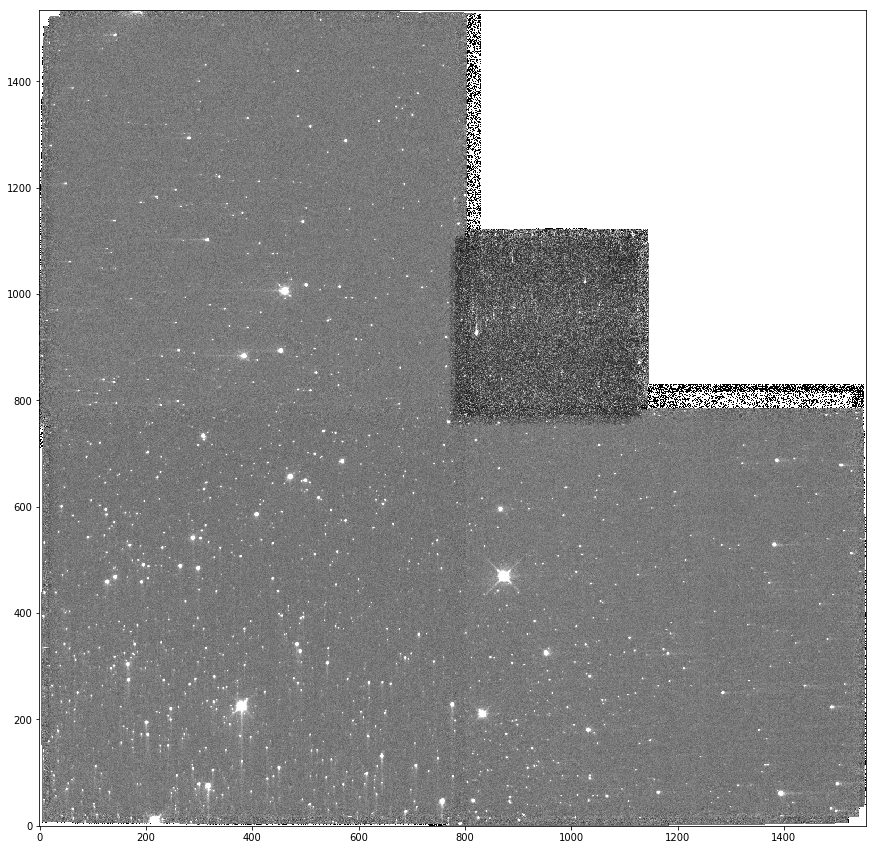

In [9]:
drz = fits.getdata('final_drz_sci.fits')
plt.figure(figsize=(15, 15))
plt.imshow(drz, cmap='gray', vmin=-0.1, vmax=0.5, origin='lower')

## 6. Illustration of the Effects of Sensitivity Variation on Drizzling

The effect of drizzling images with different detector sensitivies, while tangible, is sometimes difficult to _visualize_ in noisy data, especially when drizzling multiple dithered images that can blur the borders between chips.

In this section we produce a simple simulation of observing a constant intensity "blank sky". We then make a copy of this image and apply sensitivity equalization to it. Finally we drizzle both images and compare them side-by-side.

### Simulate an Image of Constant "Blank Sky" Background

In this simple simulation we assume only Poisson noise.

In [10]:
with fits.open(backup_image, mode='update') as h:
    # get chip inverse-sensitivity:
    phot1 = h[1].header['PHOTFLAM']
    phot2 = h[2].header['PHOTFLAM']
    phot3 = h[3].header['PHOTFLAM']
    phot4 = h[4].header['PHOTFLAM']
    
    # get chip WCS:
    w1 = HSTWCS(h, ext=1)
    w2 = HSTWCS(h, ext=2)
    w3 = HSTWCS(h, ext=3)
    w4 = HSTWCS(h, ext=4)
    ref_pscale = w4.idcscale
    
    # get chip gain:
    cmdgain = h[0].header['ATODGAIN']
    gain1 = WFPC2_GAINS[1][cmdgain][0]
    gain2 = WFPC2_GAINS[2][cmdgain][0]
    gain3 = WFPC2_GAINS[3][cmdgain][0]
    gain4 = WFPC2_GAINS[4][cmdgain][0]
    
    # final drizzle scale:
    scale = 0.0996
    
    # simulated sky level ("true" sky is constant):
    sky = 10 * phot3

    # simulate observed counts assuming only Poisson noise:
    conv1a = gain1 * (w1.idcscale / ref_pscale)**2 / phot1
    conv1b = (gain4 / gain1**2) * (ref_pscale / scale)**2
    conv2a = gain2 * (w2.idcscale / ref_pscale)**2 / phot2
    conv2b = (gain4 / gain2**2) * (ref_pscale / scale)**2
    conv3a = gain3 * (w3.idcscale / ref_pscale)**2 / phot3
    conv3b = (gain4 / gain3**2) * (ref_pscale / scale)**2
    conv4a = gain4 * (w4.idcscale / ref_pscale)**2 / phot4
    conv4b = (1.0 / gain4) * (ref_pscale / scale)**2

    h[1].data[:, :] = np.random.poisson(conv1a * sky, h[1].data.shape) * conv1b
    h[2].data[:, :] = np.random.poisson(conv2a * sky, h[2].data.shape) * conv2b
    h[3].data[:, :] = np.random.poisson(conv3a * sky, h[3].data.shape) * conv3b
    h[4].data[:, :] = np.random.poisson(conv4a * sky, h[4].data.shape) * conv4b

# make a copy of this file:
photeq_image = 'simulation_eq.fits'
if os.path.isfile(photeq_image):
    os.remove(photeq_image)
shutil.copy2(backup_image, photeq_image)

# apply equalization to the image copy:
photeq.photeq(files=photeq_image, ref_phot_ext=3, readonly=False)

***** drizzlepac.photeq started on 2019-03-26 14:55:56.038578


      Version 0.2 (06-Nov-2015)


PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM


SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU


REFERENCE VALUE FROM FILE: 'simulation_eq.fits[3]'


REFERENCE 'PHOTFLAM' VALUE IS: 2.449067e-18


Processing file 'simulation_eq.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3) - This is the "reference" extension.


          Nothing to do. Skipping this extension...


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Done.


### Drizzle the Original Simulated Image and the Equalized Image

In [11]:
astrodrizzle.AstroDrizzle(
    backup_image,
    output='nonequalized.fits',
    stepsize=1,
    preserve=False,
    restore=False,
    in_memory=True,
    context=False,
    build=False,
    static=False,
    skysub=False,
    median=False,
    blot=False,
    driz_cr=False,
    final_fillval=None,
    final_bits='',
    final_wcs=True,
    final_scale=scale)

astrodrizzle.AstroDrizzle(
    photeq_image,
    output='equalized.fits',
    stepsize=1,
    preserve=False,
    restore=False,
    in_memory=True,
    context=False,
    build=False,
    static=False,
    skysub=False,
    median=False,
    blot=False,
    driz_cr=False,
    final_fillval=None,
    final_bits='',
    final_wcs=True,
    final_scale=scale)

Setting up logfile :  astrodrizzle.log


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:55:56.136 (26/03/2019)


==== Processing Step  Initialization  started at  14:55:56.139 (26/03/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3190128059669  -0.8641404780954898  


CRPIX : 761.5219836230856  751.4609591854982  


CD1_1 CD1_2  : 5.413912551031085e-06  -2.7131789386884023e-05  


CD2_1 CD2_2  : -2.7131789386884023e-05  -5.413912551031085e-06  


NAXIS : 1522  1502


********************************************************************************


*


*  Estimated memory usage:  up to 124 Mb.


*  Output image size:       1522 X 1502 pixels. 


*  Output image file:       ~ 26 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step  Initialization  finished at  14:55:56.462 (26/03/2019)


==== Processing Step  Static Mask  started at  14:55:56.465 (26/03/2019)


==== Processing Step  Static Mask  finished at  14:55:56.465 (26/03/2019)


==== Processing Step  Subtract Sky  started at  14:55:56.467 (26/03/2019)


==== Processing Step  Subtract Sky  finished at  14:55:56.519 (26/03/2019)


==== Processing Step  Separate Drizzle  started at  14:55:56.521 (26/03/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3190128059669  -0.8641404780954898  


CRPIX : 1664.0  1642.0  


CD1_1 CD1_2  : 2.4758866581311368e-06  -1.2407890729859782e-05  


CD2_1 CD2_2  : -1.2407890729859782e-05  -2.4758866581311368e-06  


NAXIS : 3328  3284


-Generating simple FITS output: simulation_single_sci.fits


==== Processing Step  Separate Drizzle  finished at  14:56:00.370 (26/03/2019)


==== Processing Step  Create Median  started at  14:56:00.373 (26/03/2019)


==== Processing Step  Blot  started at  14:56:00.374 (26/03/2019)


==== Processing Step  Blot  finished at  14:56:00.374 (26/03/2019)


==== Processing Step  Driz_CR  started at  14:56:00.376 (26/03/2019)


==== Processing Step  Final Drizzle  started at  14:56:00.376 (26/03/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3190128059669  -0.8641404780954898  


CRPIX : 761.5219836230856  751.4609591854982  


CD1_1 CD1_2  : 5.413912551031085e-06  -2.7131789386884023e-05  


CD2_1 CD2_2  : -2.7131789386884023e-05  -5.413912551031085e-06  


NAXIS : 1522  1502


-Generating simple FITS output: nonequalized_sci.fits


Writing out image to disk: nonequalized_sci.fits


Writing out image to disk: nonequalized_wht.fits


==== Processing Step  Final Drizzle  finished at  14:56:04.612 (26/03/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:56:04.615 (26/03/2019).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.3238 sec.


            Static Mask          0.0007 sec.


           Subtract Sky          0.0519 sec.


       Separate Drizzle          3.8498 sec.


          Create Median          0.0000 sec.


                   Blot          0.0006 sec.


                Driz_CR          0.0000 sec.


          Final Drizzle          4.2353 sec.


   ====================          ====================


                  Total          8.4621 sec.


Trailer file written to:  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 14:56:04.655 (26/03/2019)


==== Processing Step  Initialization  started at  14:56:04.656 (26/03/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3190128059669  -0.8641404780954898  


CRPIX : 761.5219836230856  751.4609591854982  


CD1_1 CD1_2  : 5.413912551031085e-06  -2.7131789386884023e-05  


CD2_1 CD2_2  : -2.7131789386884023e-05  -5.413912551031085e-06  


NAXIS : 1522  1502


********************************************************************************


*


*  Estimated memory usage:  up to 124 Mb.


*  Output image size:       1522 X 1502 pixels. 


*  Output image file:       ~ 26 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step  Initialization  finished at  14:56:04.957 (26/03/2019)


==== Processing Step  Static Mask  started at  14:56:04.959 (26/03/2019)


==== Processing Step  Static Mask  finished at  14:56:04.959 (26/03/2019)


==== Processing Step  Subtract Sky  started at  14:56:04.961 (26/03/2019)


==== Processing Step  Subtract Sky  finished at  14:56:05.004 (26/03/2019)


==== Processing Step  Separate Drizzle  started at  14:56:05.005 (26/03/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3190128059669  -0.8641404780954898  


CRPIX : 1664.0  1642.0  


CD1_1 CD1_2  : 2.4758866581311368e-06  -1.2407890729859782e-05  


CD2_1 CD2_2  : -1.2407890729859782e-05  -2.4758866581311368e-06  


NAXIS : 3328  3284


-Generating simple FITS output: simulation_eq_single_sci.fits


==== Processing Step  Separate Drizzle  finished at  14:56:07.934 (26/03/2019)


==== Processing Step  Create Median  started at  14:56:07.936 (26/03/2019)


==== Processing Step  Blot  started at  14:56:07.936 (26/03/2019)


==== Processing Step  Blot  finished at  14:56:07.937 (26/03/2019)


==== Processing Step  Driz_CR  started at  14:56:07.938 (26/03/2019)


==== Processing Step  Final Drizzle  started at  14:56:07.939 (26/03/2019)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3190128059669  -0.8641404780954898  


CRPIX : 761.5219836230856  751.4609591854982  


CD1_1 CD1_2  : 5.413912551031085e-06  -2.7131789386884023e-05  


CD2_1 CD2_2  : -2.7131789386884023e-05  -5.413912551031085e-06  


NAXIS : 1522  1502


-Generating simple FITS output: equalized_sci.fits


Writing out image to disk: equalized_sci.fits


Writing out image to disk: equalized_wht.fits


==== Processing Step  Final Drizzle  finished at  14:56:11.831 (26/03/2019)


AstroDrizzle Version 2.2.6 is finished processing at 14:56:11.833 (26/03/2019).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.3003 sec.


            Static Mask          0.0009 sec.


           Subtract Sky          0.0430 sec.


       Separate Drizzle          2.9286 sec.


          Create Median          0.0000 sec.


                   Blot          0.0006 sec.


                Driz_CR          0.0000 sec.


          Final Drizzle          3.8916 sec.


   ====================          ====================


                  Total          7.1648 sec.


Trailer file written to:  astrodrizzle.log


### Display The Results of the Simulation Side-by-Side

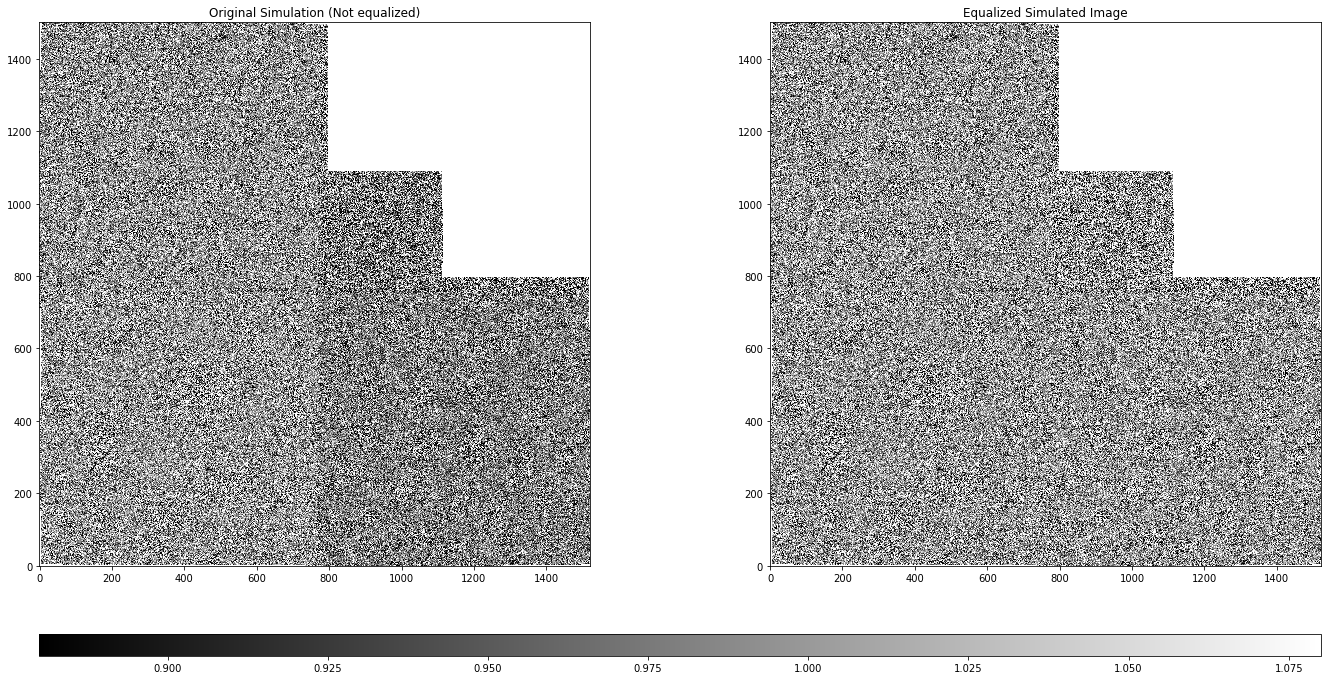

In [12]:
drz_noneq = fits.getdata('nonequalized_sci.fits')
drz_eq = fits.getdata('equalized_sci.fits')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24, 10))
im1 = ax1.imshow(drz_noneq, cmap='gray', vmin=0.88, vmax=1.08, origin='lower')
ax1.set_title('Original Simulation (Not equalized)')
im2 = ax2.imshow(drz_eq, cmap='gray', vmin=0.88, vmax=1.08, origin='lower')
ax2.set_title('Equalized Simulated Image')

x1 = ax1.get_position().get_points().flatten()[0]
x2 = ax2.get_position().get_points().flatten()[2] - x1
ax_cbar = fig.add_axes([x1, 0, x2, 0.03])
plt.colorbar(im1, cax=ax_cbar, orientation='horizontal')

# About this Notebook

    Author: M. Cara, STScI Data Analysis Tools Branch
    Updated: December 14, 2018